In [1]:
# Uncomment the line below if running in a new environment
# !pip install yfinance matplotlib scikit-learn torch

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


In [2]:
def load_data(ticker='AAPL', start='2015-01-01', end='2024-01-01', seq_length=60):
    df = yf.download(ticker, start=start, end=end)[['Close']]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(seq_length, len(scaled)):
        X.append(scaled[i - seq_length:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, seq_length, 1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, seq_length, 1)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return X_train, y_train, X_test, y_test, scaler, df



In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]  # take last output
        x = self.fc1(x)
        x = self.fc2(x)
        return x



In [4]:
def train_model(model, train_loader, epochs=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")



In [5]:
def plot_predictions(model, X_test, y_test, scaler):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).squeeze().cpu().numpy()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    actual = scaler.inverse_transform(y_test.reshape(-1, 1).cpu().numpy())

    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Stock Price Prediction (PyTorch LSTM)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
C:\Users\sahaj\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\sahaj\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([35, 1])) that is different to the input size (torch.Size([35])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 0.0679
Epoch 2/20, Loss: 0.0637
Epoch 3/20, Loss: 0.0631
Epoch 4/20, Loss: 0.0630
Epoch 5/20, Loss: 0.0632
Epoch 6/20, Loss: 0.0630
Epoch 7/20, Loss: 0.0633
Epoch 8/20, Loss: 0.0634
Epoch 9/20, Loss: 0.0631
Epoch 10/20, Loss: 0.0626
Epoch 11/20, Loss: 0.0629
Epoch 12/20, Loss: 0.0629
Epoch 13/20, Loss: 0.0629
Epoch 14/20, Loss: 0.0629
Epoch 15/20, Loss: 0.0627
Epoch 16/20, Loss: 0.0630
Epoch 17/20, Loss: 0.0630
Epoch 18/20, Loss: 0.0627
Epoch 19/20, Loss: 0.0629
Epoch 20/20, Loss: 0.0627


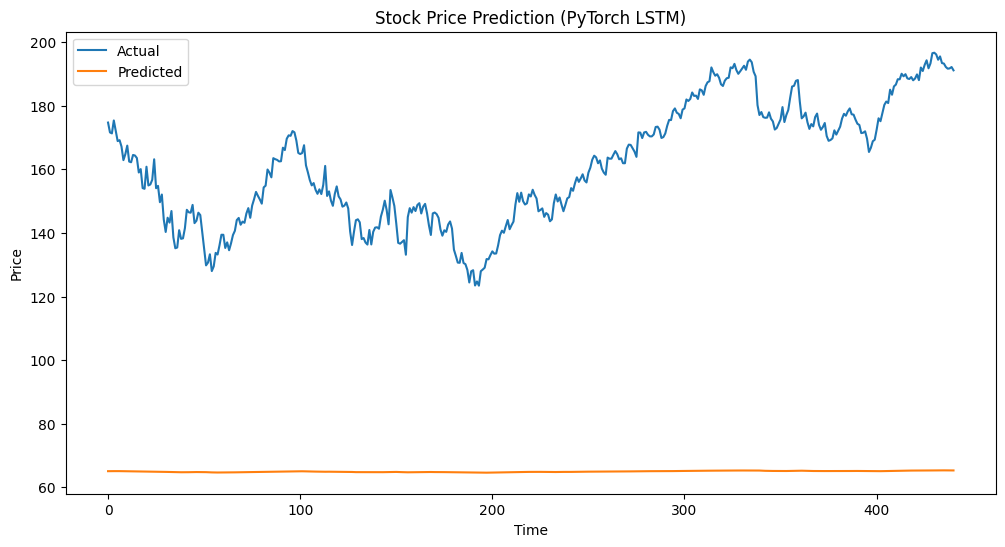

In [6]:
seq_length = 60
X_train, y_train, X_test, y_test, scaler, df = load_data(seq_length=seq_length)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = LSTMModel()
train_model(model, train_loader)
plot_predictions(model, X_test, y_test, scaler)



In [8]:
# Get last 60 days from the original dataset and scale it
last_60_days = df[-seq_length:].values
last_60_scaled = scaler.transform(last_60_days)

predicted_prices = []
current_seq = torch.tensor(last_60_scaled, dtype=torch.float32).reshape(1, seq_length, 1)

model.eval()
with torch.no_grad():
    for _ in range(30):
        pred = model(current_seq).item()
        predicted_prices.append(pred)

        # Update current_seq with the new prediction
        next_seq = torch.cat((current_seq[:, 1:, :], torch.tensor([[[pred]]])), dim=1)
        current_seq = next_seq

# Inverse transform predictions to original price scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))



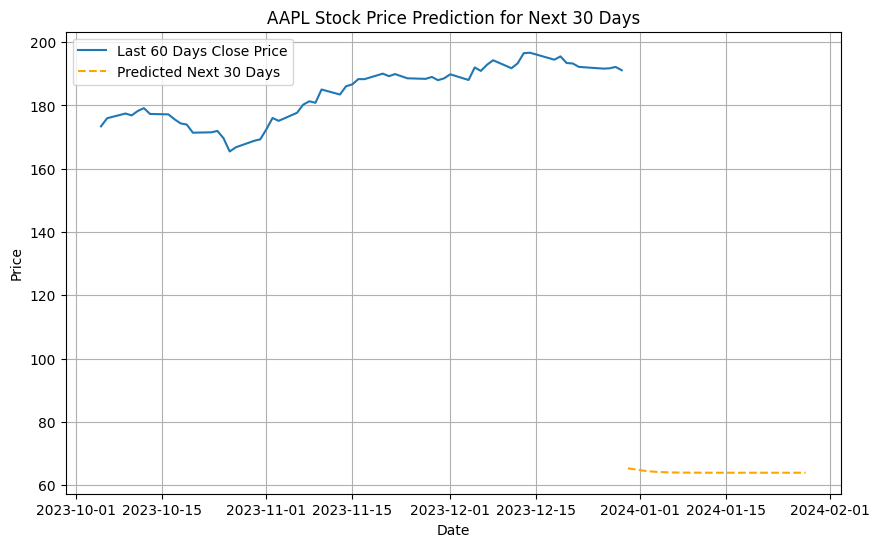

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[-60:], df['Close'].values[-60:], label='Last 60 Days Close Price')

future_dates = pd.date_range(start=df.index[-1], periods=30+1, inclusive='right')
plt.plot(future_dates, predicted_prices, label='Predicted Next 30 Days', linestyle='--', color='orange')

plt.title('AAPL Stock Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
